In [48]:
# 1. Import thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, Adamax, Ftrl
from keras.callbacks import EarlyStopping

In [49]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel("/kaggle/input/btc-data/btc_processed_data.xlsx")
df1=df.reset_index()['Close']

In [50]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [51]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [52]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [53]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [54]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [55]:
ftrl_optimizer = Ftrl(learning_rate = 0.001, l1_regularization_strength=0.0, l2_regularization_strength=0.0)

In [56]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(time_step, 1)))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100, return_sequences=True))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1))  # Output layer
model.compile(loss='mean_squared_error', optimizer=ftrl_optimizer)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 100, 100)       │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 100, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,201 (594.54 KB)

 Trainable params: 152,201 (594.54 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1703 - val_loss: 0.2980
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1656 - val_loss: 0.2944
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1576 - val_loss: 0.2917
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1533 - val_loss: 0.2894
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1538 - val_loss: 0.2874
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1526 - val_loss: 0.2856
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1697 - val_loss: 0.2839
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1548 - val_loss: 0.2824
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1557 - val_loss: 0.2810
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1508 - val_loss: 0.2796
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1603 - val_loss: 0.2783
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [58]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [59]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [60]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

test_mse = mean_squared_error(ytest, y_pred)

test_mae = mean_absolute_error(ytest, y_pred)

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Testing RMSE: {test_rmse}")
print(f"Testing MSE: {test_mse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MAPE: {test_mape}%")

Testing RMSE: 10081.05735642469
Testing MSE: 101627717.42352435
Testing MAE: 10081.05735403466
Testing MAPE: 2319962.099120287%


In [61]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.68583501 0.67756889 0.68967404 0.69201294 0.73224787 0.76921984
 0.84739737 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461
 0.86609866 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915
 0.98615743 0.97688739 1.         0.97566562 0.9469183  0.88793761
 0.93230318 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499
 0.86986376 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542
 0.95397313 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056
 0.93400854 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905
 0.96399961 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929
 0.8662525  0.82968151 0.86193771 0.86670989 0.88331172 0.88233372
 0.90990125 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873
 0.85617441 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184
 0.8674009  0.86941556 0.8568772  0.84494544 0.82840125 0.85526172
 0.82270083 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604
 0.88673257 0.91299111 0.91138888 0.90183292 0.9764

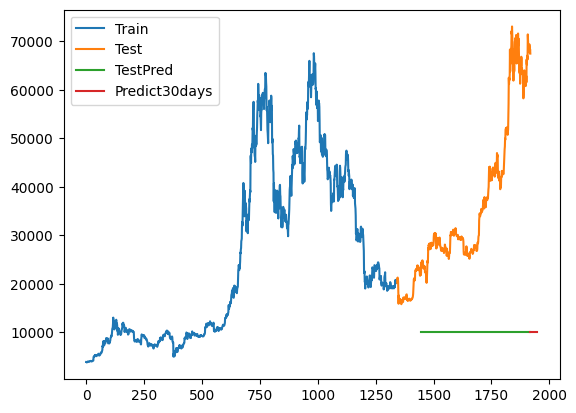

In [62]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict30days'])
plt.show()

<h2> 60 days

In [63]:
# 14. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.68583501 0.67756889 0.68967404 0.69201294 0.73224787 0.76921984
 0.84739737 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461
 0.86609866 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915
 0.98615743 0.97688739 1.         0.97566562 0.9469183  0.88793761
 0.93230318 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499
 0.86986376 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542
 0.95397313 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056
 0.93400854 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905
 0.96399961 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929
 0.8662525  0.82968151 0.86193771 0.86670989 0.88331172 0.88233372
 0.90990125 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873
 0.85617441 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184
 0.8674009  0.86941556 0.8568772  0.84494544 0.82840125 0.85526172
 0.82270083 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604
 0.88673257 0.91299111 0.91138888 0.90183292 0.9764

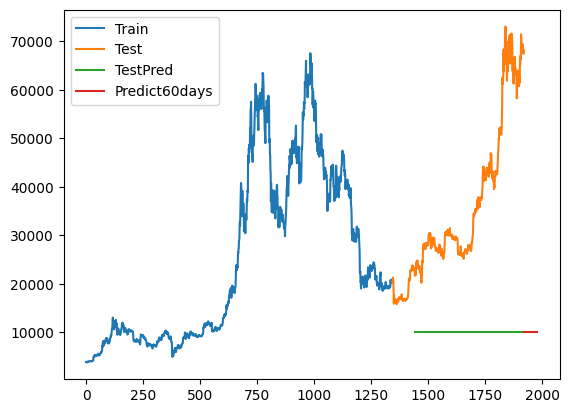

In [64]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict60days'])
plt.show()

<h2> 90 days

In [65]:
# 16. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.68583501 0.67756889 0.68967404 0.69201294 0.73224787 0.76921984
 0.84739737 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461
 0.86609866 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915
 0.98615743 0.97688739 1.         0.97566562 0.9469183  0.88793761
 0.93230318 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499
 0.86986376 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542
 0.95397313 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056
 0.93400854 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905
 0.96399961 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929
 0.8662525  0.82968151 0.86193771 0.86670989 0.88331172 0.88233372
 0.90990125 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873
 0.85617441 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184
 0.8674009  0.86941556 0.8568772  0.84494544 0.82840125 0.85526172
 0.82270083 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604
 0.88673257 0.91299111 0.91138888 0.90183292 0.9764

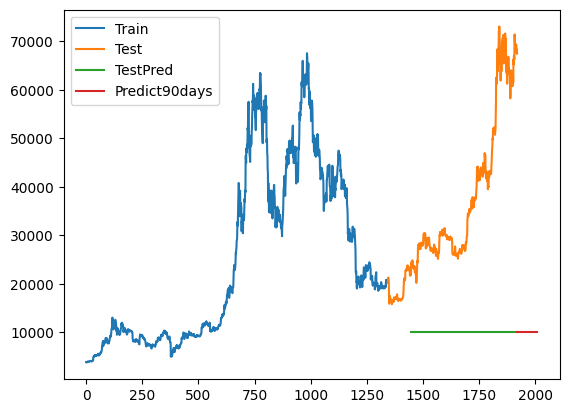

In [66]:
# 17.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict90days'])
plt.show()